Write a single **model.py** file that includes GN/LN/BN and takes an argument to decide which normalization to include

Write a single notebook file to run all the 3 models above for 20 epochs each

Create these graphs:
1.   Graph 1: Test/Validation Loss for all 3 models together
2.   Graph 2: Test/Validation Accuracy for 3 models together

Note-: Graphs must have proper annotation

Find 10 misclassified images for each of the 3 models, and show them as a 5x2 image matrix in 3 separately annotated images. 

# Import Libraries

In [9]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [10]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [11]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


#Creating instance of all the 3 Models by passing Normalization Type as a Parameter

In [13]:
!pip install torchsummary
from torchsummary import summary
import model
from model import Net
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelBN = Net('bn').to(device)
summary(modelBN, input_size=(1, 28, 28))

modelLN = Net('ln').to(device)
summary(modelLN, input_size=(1, 28, 28))

modelGN = Net('gn').to(device)
summary(modelGN, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             910
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 30, 22, 22]           2,730
       BatchNorm2d-8           [-1, 30, 22, 22]              60
              ReLU-9           [-1, 30, 22, 22]               0
        MaxPool2d-10           [-1, 30, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             310
      BatchNorm2d-12           [-1, 10, 11, 11]              20


# Training 
Let's write train function

In [14]:
def train(model, device, train_loader, optimizer, epoch, L1):
    model.train()
    epoch_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        if L1:
          L1_loss = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
          reg_loss = 0 
          for param in model.parameters():
            zero_vector = torch.rand_like(param) * 0
            reg_loss += L1_loss(param,zero_vector)
          loss += .001 * reg_loss

        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

# Testing
Let's write testing function

In [15]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    test_pred = torch.LongTensor()
    target_pred = torch.LongTensor()
    target_data = torch.LongTensor()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_cpu = output.cpu().data.max(dim=1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_pred = torch.cat((test_pred, pred_cpu), dim=0)
            target_pred = torch.cat((target_pred, target.cpu()), dim=0)
            target_data = torch.cat((target_data, data.cpu()), dim=0)


    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc, test_pred, target_pred, target_data

#displayMisClassificationImages function to display ten misclassified images

In [16]:
def displayMisClassificationImages(predictions, targets, data, xtitle):
    pred = predictions.view(-1)
    target = targets.view(-1)

    index = 0
    misclassified_image = []
    
    for label, predict in zip(target, pred):
      if label != predict:
        misclassified_image.append(index)
      index += 1

    plt.figure(figsize=(10,5))
    plt.suptitle(xtitle + ' - Misclassified Images');

    for plot_index, bad_index in enumerate(misclassified_image[0:10]):
      p = plt.subplot(2, 5, plot_index+1)
      p.imshow(data[bad_index].reshape(28,28), cmap='gray')
      p.axis('off')
      p.set_title(f'Pred:{pred[bad_index]}, Actual:{target[bad_index]}')

# A main function calling test and train functions

#Input Params

*   EPOCHS
*   model
*   device
*   train_loader
*   test_loader
*   optimizer
*   L1 (Lasso Regression is true or false)

#OutPut Params
* train_loss_values
* test_loss_values
* train_acc_values
* test_acc_values
* test_pred
* target_pred
* target_data


In [17]:
def main(EPOCHS, model, device, train_loader, test_loader, optimizer, L1):
  train_loss_values = []
  test_loss_values = []
  train_acc_values = []
  test_acc_values = []

  for epoch in range(EPOCHS):
      print('\nEpoch {} : '.format(epoch))
      # train the model
      train_loss, train_acc = train(model, device, train_loader, optimizer, epoch, L1)
      test_loss, test_acc, test_pred, target_pred, target_data  = test(model, device, test_loader)

      train_loss_values.append(train_loss)
      test_loss_values.append(test_loss)

      train_acc_values.append(train_acc)
      test_acc_values.append(test_acc)

  return train_loss_values, test_loss_values, train_acc_values, test_acc_values, test_pred, target_pred, target_data

# Calling all the three Models with(BN/LN/GN) with 20 Epochs

In [18]:
EPOCHS = 20
model_BN =  Net('bn').to(device)
optimizer = optim.SGD(model_BN.parameters(), lr=0.04, momentum=0.9)
l1reg = False
BN_train_loss, BN_test_loss, BN_train_acc, BN_test_acc , BN_test_pred, BN_target_pred, BN_target_data = main(EPOCHS, model_BN, device, train_loader,test_loader,optimizer,l1reg)


model_LN =  Net('ln').to(device)
optimizer = optim.SGD(model_LN.parameters(), lr=0.04, momentum=0.9)
l1reg = False
LN_train_loss, LN_test_loss, LN_train_acc, LN_test_acc , LN_test_pred, LN_target_pred, LN_target_data= main(EPOCHS, model_LN, device, train_loader,test_loader,optimizer,l1reg)


model_GN =  Net('gn').to(device)
optimizer = optim.SGD(model_GN.parameters(), lr=0.04, momentum=0.9)
l1reg = False
GN_train_loss, GN_test_loss, GN_train_acc, GN_test_acc, GN_test_pred, GN_target_pred, GN_target_data = main(EPOCHS, model_GN, device, train_loader,test_loader,optimizer,l1reg)





Epoch 0 : 
Train set: Average loss: 0.1282, Accuracy: 92.89

Test set: Average loss: 0.084, Accuracy: 97.76

Epoch 1 : 
Train set: Average loss: 0.0912, Accuracy: 97.62

Test set: Average loss: 0.087, Accuracy: 97.59

Epoch 2 : 
Train set: Average loss: 0.0094, Accuracy: 97.94

Test set: Average loss: 0.041, Accuracy: 98.75

Epoch 3 : 
Train set: Average loss: 0.0495, Accuracy: 98.23

Test set: Average loss: 0.052, Accuracy: 98.57

Epoch 4 : 
Train set: Average loss: 0.1233, Accuracy: 98.39

Test set: Average loss: 0.036, Accuracy: 99.00

Epoch 5 : 
Train set: Average loss: 0.0413, Accuracy: 98.48

Test set: Average loss: 0.034, Accuracy: 99.00

Epoch 6 : 
Train set: Average loss: 0.0971, Accuracy: 98.61

Test set: Average loss: 0.028, Accuracy: 99.17

Epoch 7 : 
Train set: Average loss: 0.0113, Accuracy: 98.67

Test set: Average loss: 0.029, Accuracy: 99.14

Epoch 8 : 
Train set: Average loss: 0.0577, Accuracy: 98.75

Test set: Average loss: 0.027, Accuracy: 99.29

Epoch 9 : 
Train s

#Plotting the below graphs 
Graph 1: Test/Validation Loss for all 3 models together for 20 Epochs

Graph 2: Test/Validation Accuracy for 3 models together for 20 Epochs

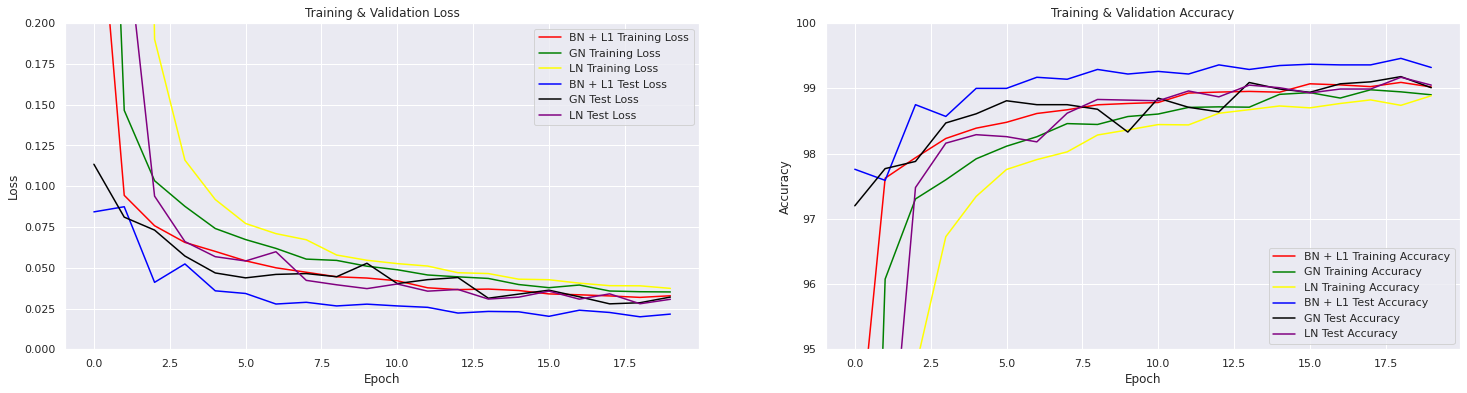

In [19]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(BN_train_loss), 'red', label="BN + L1 Training Loss")
ax1.plot(np.array(GN_train_loss), 'green', label="GN Training Loss")
ax1.plot(np.array(LN_train_loss), 'yellow', label="LN Training Loss")
ax1.plot(np.array(BN_test_loss), 'blue', label="BN + L1 Test Loss")
ax1.plot(np.array(GN_test_loss), 'black', label="GN Test Loss")
ax1.plot(np.array(LN_test_loss), 'purple', label="LN Test Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_ylim(0,0.2)
ax1.legend()

ax2.plot(np.array(BN_train_acc), 'red', label="BN + L1 Training Accuracy")
ax2.plot(np.array(GN_train_acc), 'green', label="GN Training Accuracy")
ax2.plot(np.array(LN_train_acc), 'yellow', label="LN Training Accuracy")
ax2.plot(np.array(BN_test_acc), 'blue', label="BN + L1 Test Accuracy")
ax2.plot(np.array(GN_test_acc), 'black', label="GN Test Accuracy")
ax2.plot(np.array(LN_test_acc), 'purple', label="LN Test Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(95,100)
ax2.legend()

plt.show()

Displaying Misclassified Iamges for Batch Normalization

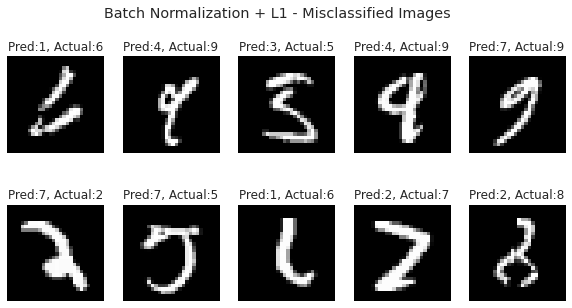

In [20]:
displayMisClassificationImages(BN_test_pred, BN_target_pred, BN_target_data, 'Batch Normalization + L1')

Displaying Misclassified Iamges for Layer Normalization

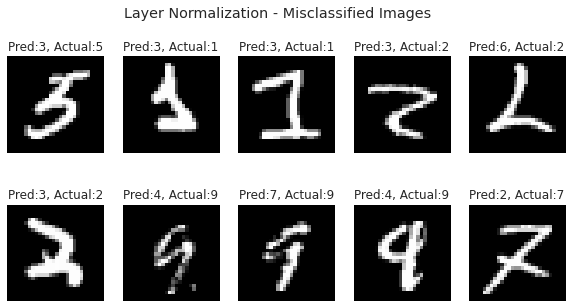

In [21]:
displayMisClassificationImages(LN_test_pred, LN_target_pred, LN_target_data, 'Layer Normalization')

Displaying Misclassified Iamges for Group Normalization

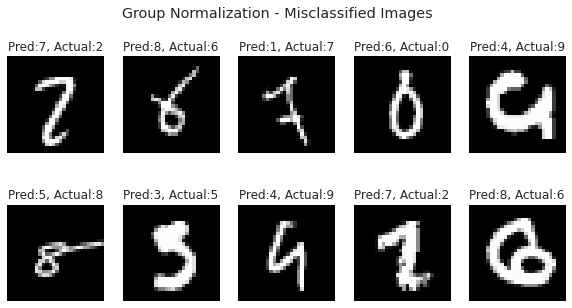

In [22]:
displayMisClassificationImages(GN_test_pred, GN_target_pred, GN_target_data, 'Group Normalization')